# FEAT method

#### Importation of the librairies

In [1]:
import pandas as pd
import math

In [2]:
# !pip install nb_black

In [3]:
%load_ext nb_black
# réglé par défaut à 120 caractères par colonne

<IPython.core.display.Javascript object>

### List of the eurocontrol flights

In [4]:
df_flights = (
    pd.read_csv("flights_eurocontrol.csv")
    .rename(columns={"Actual Distance Flown (nm)": "Distance_nm"})
    .eval("distance_km= Distance_nm*1.852")
)


df_eurocontrol = (
    df_flights.query(
        '(ADEP.str.startswith("E") | ADEP.str.startswith("L")) & (ADES.str.startswith("E") | ADES.str.startswith("L"))'
    )
    .drop(
        columns=[
            "FILED OFF BLOCK TIME",
            "FILED ARRIVAL TIME",
            "ACTUAL OFF BLOCK TIME",
            "ACTUAL ARRIVAL TIME",
            "AC Operator",
            "AC Registration",
        ]
    )
    .rename(columns={"ECTRL ID": "ID", "AC Type": "AC_Type"})
)

df_eurocontrol.head()

,ID,ADEP,ADEP Latitude,ADEP Longitude,ADES,ADES Latitude,ADES Longitude,AC_Type,ICAO Flight Type,STATFOR Market Segment,Requested FL,Distance_nm,distance_km
0,242070088,EDDP,51.42389,12.23639,EGMC,51.57028,0.69333,B734,S,All-Cargo,320.0,435,805.620
1,242072146,EDDK,50.86583,7.14278,LFLL,45.72556,5.08111,B734,S,All-Cargo,240.0,350,648.200
2,242074255,EPKT,50.47417,19.08000,EDDK,50.86583,7.14278,B734,S,All-Cargo,280.0,481,890.812
4,242075583,EDDV,52.46028,9.68361,EGNX,52.83111,-1.32778,B734,S,All-Cargo,340.0,416,770.432
5,242076646,EGTE,50.73417,-3.41389,EGNX,52.83111,-1.32778,B734,S,All-Cargo,210.0,169,312.988


<IPython.core.display.Javascript object>

In [5]:
df_eurocontrol.query("ADEP == 'EDDP' & ADES == 'EGNX'").groupby("AC_Type").count().sum()

ID                        210
ADEP                      210
ADEP Latitude             210
ADEP Longitude            210
ADES                      210
ADES Latitude             210
ADES Longitude            210
ICAO Flight Type          210
STATFOR Market Segment    210
Requested FL              210
Distance_nm               210
distance_km               210
dtype: int64

<IPython.core.display.Javascript object>

### List of the existing airports

In [6]:
df_airports = pd.read_csv("airports.csv")
df_airports.head(3)

,name,iata,icao,latitude,longitude,country,altitude,type,municipality
0,Honiara International Airport,HIR,AGGH,-9.428000,160.054993,Solomon Islands,28.0,large_airport,Honiara
1,Munda Airport,MUA,AGGM,-8.327970,157.263000,Solomon Islands,10.0,medium_airport,Munda
2,Nauru International Airport,INU,ANYN,-0.547458,166.919006,Nauru,22.0,medium_airport,Yaren District


<IPython.core.display.Javascript object>

### FEAT estimation of the fuel consumption

The fuel consumption is determined from the formula :
$$F_i = \alpha_i \cdot d_{gc}^2 + \beta_i \cdot d_{gc} + \gamma_i$$
Where $\alpha_i$, $\beta_i$ and $\gamma_i$ are parameters that are calculated from the OAG dataset and can be find in the following github page : https://github.com/kwdseymour/FEAT 

In [7]:
# Importation of the coefficients and calculus of the fuel consumption
df_FEAT = (
    pd.read_csv("feat_coefficients.csv")
    .drop(columns=["Unnamed: 0"])
    .rename(columns={"ac_code_icao": "code_icao"})
)
df_FEAT.head()

,code_icao,e_type,wake,reduced_fuel_a1,reduced_fuel_a2,reduced_fuel_intercept,reduced_fuel_score,reduced_sample_size
0,A140,Turboprop,M,0.000157,1.298278,160.624472,0.999946,25
1,A148,Jet,M,0.000064,1.757268,971.035823,0.999795,25
2,A158,Jet,M,0.000033,2.566019,799.939398,0.999353,24
3,A20N,Jet,M,0.000057,2.382220,955.977183,0.999824,25
4,A21N,Jet,M,0.000063,2.723659,1121.938176,0.999939,25


<IPython.core.display.Javascript object>

### Estimation of the pax + the fuel consumption

In [8]:
# Hyperparamètre clef
filling_rate = 0.85

<IPython.core.display.Javascript object>

In [9]:
df_planes_pax = pd.read_csv("planes.csv", sep=";")

df_planes_pax.head(3)

,code_icao,min_pax,max_pax
0,A140,52,54
1,A20N,150,180
2,A21N,180,244


<IPython.core.display.Javascript object>

In [10]:
df_planes_pax_FEAT = pd.merge(df_FEAT, df_planes_pax, on="code_icao")

# Importation of the coefficients and calculus of the fuel consumption
df_planes_pax_FEAT = (
    pd.merge(
        df_eurocontrol, df_planes_pax_FEAT, left_on="AC_Type", right_on="code_icao"
    )
    .eval("pax = floor(min_pax*@filling_rate)")
    .eval(
        "fuel_consumption_kg= distance_km**2 * reduced_fuel_a1 + distance_km *reduced_fuel_a2 + reduced_fuel_intercept"
    )
)

print("Pax (M): {0:0.2f}".format(df_planes_pax_FEAT.pax.sum() / 1000 / 1000))

df_planes_pax_FEAT.head()

Pax (M): 17.14


,ID,ADEP,ADEP Latitude,ADEP Longitude,ADES,ADES Latitude,ADES Longitude,AC_Type,ICAO Flight Type,STATFOR Market Segment,...,wake,reduced_fuel_a1,reduced_fuel_a2,reduced_fuel_intercept,reduced_fuel_score,reduced_sample_size,min_pax,max_pax,pax,fuel_consumption_kg
0,242070088,EDDP,51.42389,12.23639,EGMC,51.57028,0.69333,B734,S,All-Cargo,...,M,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,3821.571627
1,242072146,EDDK,50.86583,7.14278,LFLL,45.72556,5.08111,B734,S,All-Cargo,...,M,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,3292.382381
2,242074255,EPKT,50.47417,19.08000,EDDK,50.86583,7.14278,B734,S,All-Cargo,...,M,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,4110.109742
3,242075583,EDDV,52.46028,9.68361,EGNX,52.83111,-1.32778,B734,S,All-Cargo,...,M,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,3702.834159
4,242076646,EGTE,50.73417,-3.41389,EGNX,52.83111,-1.32778,B734,S,All-Cargo,...,M,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,2182.725192


<IPython.core.display.Javascript object>

In [11]:
"FE Turboprop insatisfaisant"

#On estime les émissions du trafic aérien de notre dataset

df_planes_pax_FEAT = pd.concat(
    [
        df_planes_pax_FEAT.query("e_type == 'Jet'").eval("Emissions = fuel_consumption_kg*3.16"),
        df_planes_pax_FEAT.query("e_type == 'Piston'").eval(
            "Emissions = fuel_consumption_kg*3.10"
        ),
        df_planes_pax_FEAT.query("e_type == 'Turboprop'").eval(
            "Emissions = fuel_consumption_kg*3.16"
        )
    ]
)


nb_flights = rows = len(df_planes_pax_FEAT.axes[0])

#results
print("Number of flights: {0:d}".format(nb_flights))
print("Emissions (MtCO2) : {0:0.2f}".format(df_planes_pax_FEAT.Emissions.sum()/1000/1000/1000))
df_planes_pax_FEAT.head()


Number of flights: 155993
Emissions (MtCO2) : 1.79


,ID,ADEP,ADEP Latitude,ADEP Longitude,ADES,ADES Latitude,ADES Longitude,AC_Type,ICAO Flight Type,STATFOR Market Segment,...,reduced_fuel_a1,reduced_fuel_a2,reduced_fuel_intercept,reduced_fuel_score,reduced_sample_size,min_pax,max_pax,pax,fuel_consumption_kg,Emissions
0,242070088,EDDP,51.42389,12.23639,EGMC,51.57028,0.69333,B734,S,All-Cargo,...,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,3821.571627,12076.166342
1,242072146,EDDK,50.86583,7.14278,LFLL,45.72556,5.08111,B734,S,All-Cargo,...,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,3292.382381,10403.928325
2,242074255,EPKT,50.47417,19.08000,EDDK,50.86583,7.14278,B734,S,All-Cargo,...,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,4110.109742,12987.946785
3,242075583,EDDV,52.46028,9.68361,EGNX,52.83111,-1.32778,B734,S,All-Cargo,...,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,3702.834159,11700.955942
4,242076646,EGTE,50.73417,-3.41389,EGNX,52.83111,-1.32778,B734,S,All-Cargo,...,0.000104,3.210174,1167.77325,0.999983,25,146,188,124.0,2182.725192,6897.411607


<IPython.core.display.Javascript object>

### We consider flights that are in France

In [12]:
df_airports_france = pd.read_csv(
    "airports_france.csv", sep=";", encoding="cp1252"
).drop(columns=["City served / location"])


df_airports_france.head()

,ICAO,Airport name,Usage
0,LFOI,Aerodrome Abbeville,Public
1,LFBA,Agen La Garenne Airport,Public
2,LFDA,Aire-sur-l'Adour Airport,Public
3,LFMA,Aix-en-Provence Aerodrome (BA 114),Public/mil.
4,LFKJ,Ajaccio Napoleon Bonaparte Airport,Public


<IPython.core.display.Javascript object>

In [13]:
# x = aéroport de départ, y = aéroport d'arrivée
df_planes_pax_FEAT_france = df_planes_pax_FEAT.merge(
    df_airports_france, how="inner", left_on="ADEP", right_on="ICAO"
).merge(df_airports_france, how="inner", left_on="ADES", right_on="ICAO")


# Results
nb_flights_france = rows = len(df_planes_pax_FEAT_france.axes[0])
print("Number of flights: {0:d}".format(nb_flights_france))
print(
    "Emissions (ktCO2) : {0:0.2f}".format(
        df_planes_pax_FEAT_france.Emissions.sum() / 1000 / 1000
    )
)
df_planes_pax_FEAT_france.head()

Number of flights: 9273
Emissions (ktCO2) : 76.49


,ID,ADEP,ADEP Latitude,ADEP Longitude,ADES,ADES Latitude,ADES Longitude,AC_Type,ICAO Flight Type,STATFOR Market Segment,...,max_pax,pax,fuel_consumption_kg,Emissions,ICAO_x,Airport name_x,Usage_x,ICAO_y,Airport name_y,Usage_y
0,242074569,LFPG,49.00972,2.54778,LFMT,43.58333,3.96139,B734,S,All-Cargo,...,188,124.0,3360.574819,10619.416427,LFPG,Charles de Gaulle Airport,Public,LFMT,Montpellier–Méditerranée Airport,Public
1,242083216,LFPG,49.00972,2.54778,LFMT,43.58333,3.96139,B734,S,All-Cargo,...,188,124.0,3366.778419,10639.019805,LFPG,Charles de Gaulle Airport,Public,LFMT,Montpellier–Méditerranée Airport,Public
2,242096986,LFPG,49.00972,2.54778,LFMT,43.58333,3.96139,B734,S,All-Cargo,...,188,124.0,3435.065195,10854.806016,LFPG,Charles de Gaulle Airport,Public,LFMT,Montpellier–Méditerranée Airport,Public
3,242097706,LFPG,49.00972,2.54778,LFMT,43.58333,3.96139,B734,S,All-Cargo,...,188,124.0,3286.187357,10384.352048,LFPG,Charles de Gaulle Airport,Public,LFMT,Montpellier–Méditerranée Airport,Public
4,242111621,LFPG,49.00972,2.54778,LFMT,43.58333,3.96139,B734,S,All-Cargo,...,188,124.0,3354.371933,10599.815308,LFPG,Charles de Gaulle Airport,Public,LFMT,Montpellier–Méditerranée Airport,Public


<IPython.core.display.Javascript object>

/tmp/ipykernel_207/1432137323.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_planes_pax_FEAT_france[["ADEP", "ADES", "Emissions"]]


<AxesSubplot: xlabel='ADES'>

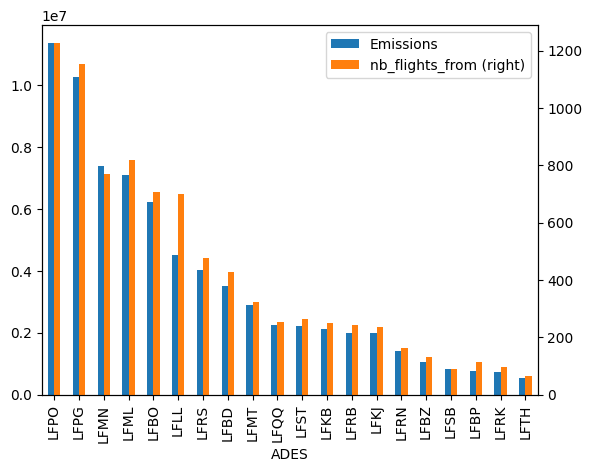

<IPython.core.display.Javascript object>

In [86]:
# da = departure airport, aa = arrival airport
df_da_emissions = (
    df_planes_pax_FEAT_france[["ADEP", "ADES", "Emissions"]]
    .groupby("ADES")
    .sum()
    .sort_values("Emissions", ascending=False)
)

# .values_count() compte les paires
df_da_nb_flights = pd.DataFrame(
    df_planes_pax_FEAT_france[["ADEP", "ADES"]].value_counts("ADES"),
    columns=["nb_flights_from"],
)

df_da_full = pd.merge(df_da_emissions, df_da_nb_flights, on="ADES")


df_da_full.head(20).plot(kind="bar", secondary_y="nb_flights_from")
# df_da_aa_emissions_full.head(10).sum()

# df_da_nb_flights

##### We test the number of flight that are in Europe

Utiliser FEAT pour tous les vols
OpenAP : plus de degrés de liberté (ex infuence du taux de remplissage, influence de la masse) --> dépend de nos critères d'optimisation. 

## Optimization

1st : pas de train si trajet direct 
capacité moyenne pour avoir le nombre total de passagers 
modélisation du probleme pour la semaine pro

# Étude des passagers

### 1. Nombre de pax par avion